# Duplicate image detecting methods using OpenCV

## Setup

In [106]:
# pip install opencv-python numpy matplotlib

In [107]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass


In [108]:
@dataclass
class SiftConfig:
    edge_threshold: int
    duplicate_descriptor_matches_threshold: int
    bf_matches_norm_type: int

@dataclass
class Config:
    sift: SiftConfig
    
config = Config(
        SiftConfig(
            edge_threshold=80,
            duplicate_descriptor_matches_threshold=150,
            bf_matches_norm_type=cv2.NORM_L2
        )
    )

['./testimages/bmw.jpg', './testimages/bmw2.jpg', './testimages/bmw3.jpg', './testimages/bmw_org.jpg', './testimages/gandalf1.jpg', './testimages/gandalf2.jpg']


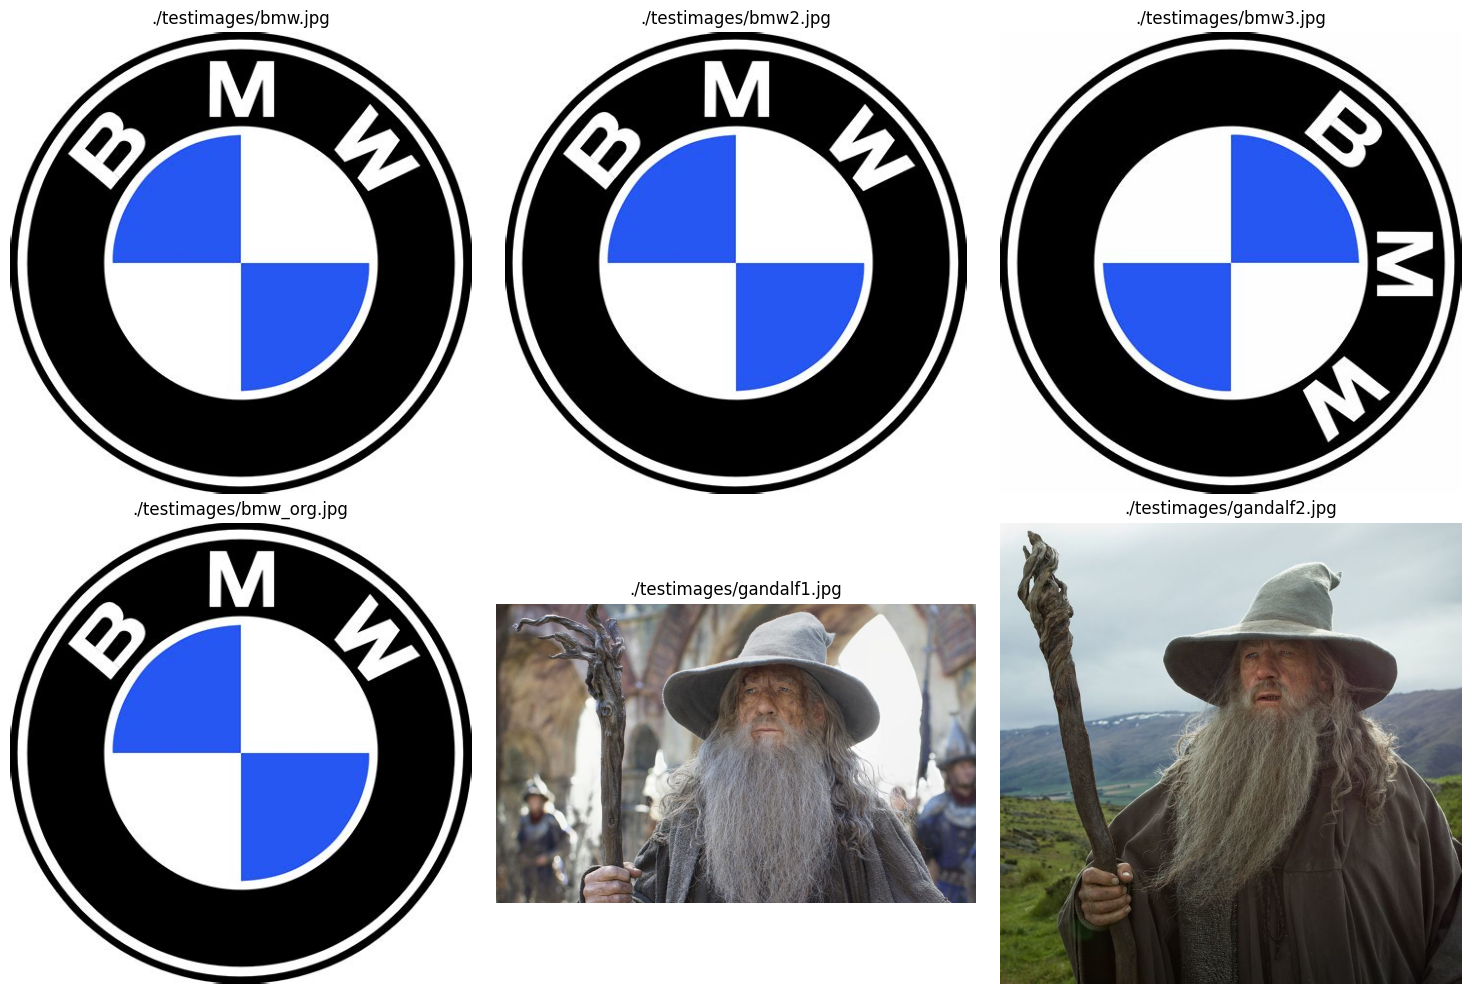

In [109]:
def load_images_from_folder(folder) -> list:
    return [os.path.join(folder, filename) for filename in os.listdir(folder)]

images = sorted(load_images_from_folder('./testimages'))

print(images)


num_images = len(images)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for idx, path in enumerate(images):

    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    ax.imshow(image, cmap='gray')
    ax.set_title(path)
    ax.axis('off')
 
    
plt.tight_layout()
plt.show()


## SIFT

In [110]:
# https://docs.opencv.org/4.10.0/d7/d60/classcv_1_1SIFT.html

sift : cv2.SIFT = cv2.SIFT_create(edgeThreshold=int(config.sift.edge_threshold))

@dataclass
class ComputedImage:
    keypoints: list
    descriptors: np.ndarray
    greyscale_image: np.ndarray

computed_images = {}
for path in images:
    
    image = cv2.imread(path)
    if image is None:
        continue
    
    greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    kp, ds = sift.detectAndCompute(greyscale_image, None)

    computed_images[path] = ComputedImage(kp, ds, greyscale_image)

### BFMatcher

In [111]:
# Find similar images using BFMatcher
# https://docs.opencv.org/4.10.0/d3/da1/classcv_1_1BFMatcher.html

matcher = cv2.BFMatcher(config.sift.bf_matches_norm_type, crossCheck=True)

unique_pairs = set()
similar_images = {}
for source_file in computed_images:
    for target_file in computed_images:
        if source_file == target_file:
            continue

        pair = tuple(sorted([source_file, target_file]))        
        if pair in unique_pairs:
            continue

        unique_pairs.add(pair)
        
        matches = matcher.match(computed_images[source_file].descriptors, computed_images[target_file].descriptors)

        num_matches = len(matches)
        
        if (num_matches < config.sift.duplicate_descriptor_matches_threshold):
            print(f"{source_file} - {target_file} - #matches: {num_matches} (SKIPPED)")
            continue
                
        similar_images.update(
            {
                source_file: {
                    target_file: {
                        'matches': matches,
                    }
                }
            }
        )

        print(f"{source_file} - {target_file} - #matches: {num_matches}")

./testimages/bmw.jpg - ./testimages/bmw2.jpg - #matches: 1021
./testimages/bmw.jpg - ./testimages/bmw3.jpg - #matches: 574
./testimages/bmw.jpg - ./testimages/bmw_org.jpg - #matches: 1021
./testimages/bmw.jpg - ./testimages/gandalf1.jpg - #matches: 124 (SKIPPED)
./testimages/bmw.jpg - ./testimages/gandalf2.jpg - #matches: 96 (SKIPPED)
./testimages/bmw2.jpg - ./testimages/bmw3.jpg - #matches: 574
./testimages/bmw2.jpg - ./testimages/bmw_org.jpg - #matches: 1021
./testimages/bmw2.jpg - ./testimages/gandalf1.jpg - #matches: 124 (SKIPPED)
./testimages/bmw2.jpg - ./testimages/gandalf2.jpg - #matches: 96 (SKIPPED)
./testimages/bmw3.jpg - ./testimages/bmw_org.jpg - #matches: 574
./testimages/bmw3.jpg - ./testimages/gandalf1.jpg - #matches: 129 (SKIPPED)
./testimages/bmw3.jpg - ./testimages/gandalf2.jpg - #matches: 97 (SKIPPED)
./testimages/bmw_org.jpg - ./testimages/gandalf1.jpg - #matches: 124 (SKIPPED)
./testimages/bmw_org.jpg - ./testimages/gandalf2.jpg - #matches: 96 (SKIPPED)
./testimage

In [112]:
# Sort duplicates by #matches
sorted_similar_images = {}

for file in similar_images.keys():
    sorted_similar_images[file] = {k: v for k, v in sorted(similar_images[file].items(), key=lambda x: x[1]['matches'], reverse=True)}

./testimages/bmw.jpg - ./testimages/bmw_org.jpg - #matches: 1021


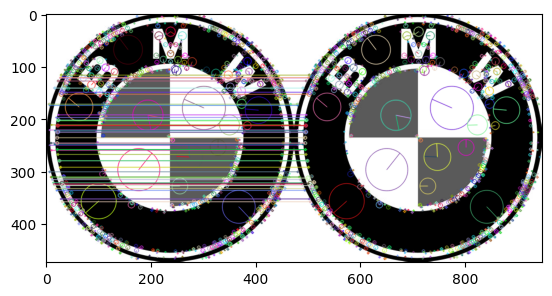

./testimages/bmw2.jpg - ./testimages/bmw_org.jpg - #matches: 1021


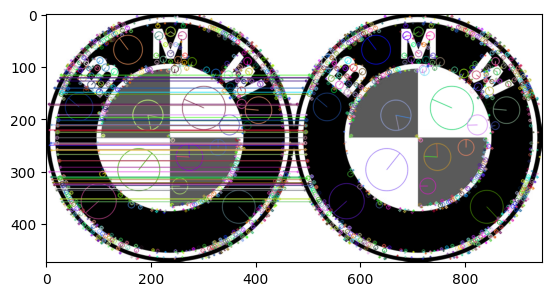

./testimages/bmw3.jpg - ./testimages/bmw_org.jpg - #matches: 574


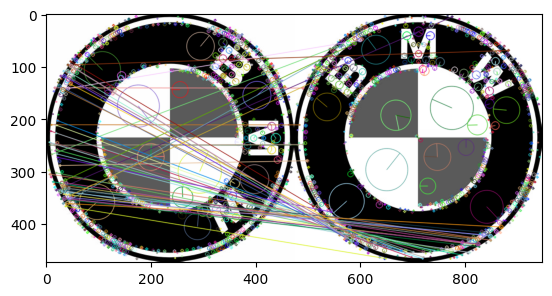

./testimages/gandalf1.jpg - ./testimages/gandalf2.jpg - #matches: 437


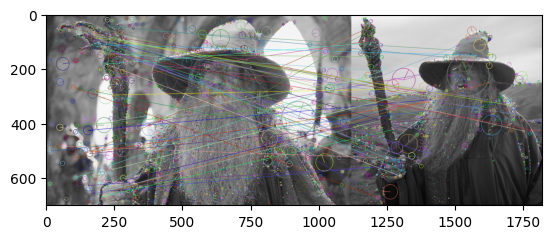

In [113]:
# Draw matches
for image in sorted_similar_images:
    first_match = list(sorted_similar_images[image].keys())[0]
    
    img1 = computed_images[image].greyscale_image
    kp1 = computed_images[image].keypoints
    img2 = computed_images[first_match].greyscale_image
    kp2 = computed_images[first_match].keypoints
    matches = sorted_similar_images[image][first_match]['matches']

    dup = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    print(f"{image} - {first_match} - #matches: {len(matches)}")
    plt.figure(image)
    plt.imshow(dup)
    plt.show()

## FLANN matcher

In [114]:
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# https://docs.opencv.org/4.10.0/dc/de2/classcv_1_1FlannBasedMatcher.html

# SURF

# ORB